# Plant Pathology Training Notebook

In [1]:
from fastai.vision.all import *
torch.cuda.set_device(0)
%config Completer.use_jedi = False
%matplotlib inline

Set hyperparameters for the notebook here:

In [2]:
# Hyperparameters
valid_pct = 0.2

In [3]:
path = Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/')
path.ls()

(#5) [Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/test_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/sample_submission.csv'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/plant-pathology-2021-fgvc8.zip'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train.csv')]

In [4]:
Path.BASE_PATH = path

In [5]:
(path/'train_images').ls()

(#18632) [Path('train_images/d7707b87601e9721.jpg'),Path('train_images/f1c0918f0b1ff4d8.jpg'),Path('train_images/9fd08acafc84e664.jpg'),Path('train_images/d4eccc89612723b7.jpg'),Path('train_images/bc287d94706dd853.jpg'),Path('train_images/90fc3c90d72f05f4.jpg'),Path('train_images/b5d7d2cdcf0d0c04.jpg'),Path('train_images/e07485de9fbca409.jpg'),Path('train_images/a7b91490d7de5a82.jpg'),Path('train_images/dce254af368e2658.jpg')...]

In [6]:
(path/'test_images').ls()

(#3) [Path('test_images/c7b03e718489f3ca.jpg'),Path('test_images/85f8cb619c66b863.jpg'),Path('test_images/ad8770db05586b59.jpg')]

The labels of the training images are in `train.csv` which has a space delimited list of labels for each image.

In [7]:
df = pd.read_csv(path/'train.csv')
df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


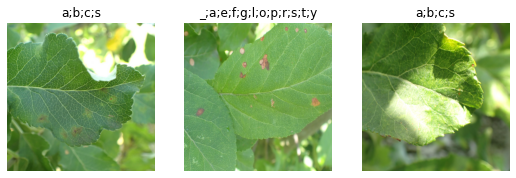

In [8]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct, seed=42),
    item_tfms=RandomResizedCrop(540, min_scale=0.35)
)

# dsets = dblock.datasets(df)
# dsets.train[0]
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [9]:
learn = cnn_learner(dls, arch=resnet18)

/home/xar/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
x,y = to_cpu(dls.train.one_batch())
activations = learn.model(x)
activations.shape

torch.Size([64, 22])

In [11]:
activations[0]

tensor([-1.2094, -4.0727,  0.2894, -6.1651, -0.3345,  0.3959, -2.4809,  0.4347,
        -1.7084, -0.7332, -3.3709, -0.8294, -2.0845,  2.9083, -2.7391,  0.2727,
         0.0365, -2.7806,  1.8299, -3.2718,  5.1385, -3.3966],
       grad_fn=<SelectBackward>)

In [12]:
loss_func = nn.BCEWithLogitsLoss()

In [13]:
loss_func(activations, y)

TensorMultiCategory(1.0553, grad_fn=<AliasBackward>)

### Fine-tune a Resnet18

SuggestedLRs(valley=0.001737800776027143)

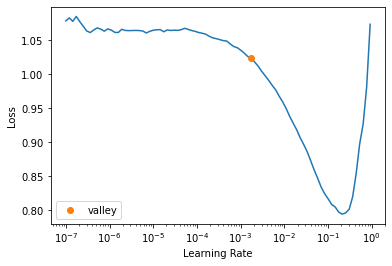

In [15]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet18_vl'
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.741253,0.539350,0.599606,11:50
1,0.397916,0.268422,0.779684,11:51
2,0.258280,0.212188,0.817520,11:54
3,0.227059,0.184069,0.841124,11:52


Better model found at epoch 0 with valid_loss value: 0.5393502712249756.


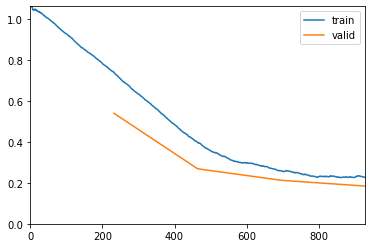

Better model found at epoch 1 with valid_loss value: 0.2684224843978882.
Better model found at epoch 2 with valid_loss value: 0.21218827366828918.
Better model found at epoch 3 with valid_loss value: 0.18406857550144196.


epoch,train_loss,valid_loss,f1_score,time
0,0.183544,0.146562,0.865460,12:00
1,0.155447,0.137065,0.869855,11:59
2,0.138762,0.126728,0.882035,12:00
3,0.118787,0.116518,0.895290,12:02
4,0.108088,0.122940,0.884011,12:01
5,0.094038,0.119973,0.898791,11:59
6,0.077748,0.120489,0.898314,11:58
7,0.063173,0.122404,0.901480,12:00
8,0.053003,0.121342,0.906214,12:01
9,0.052278,0.122277,0.906163,12:03


Better model found at epoch 0 with valid_loss value: 0.1465623676776886.


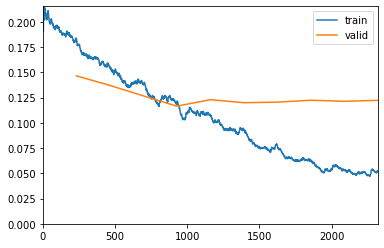

Better model found at epoch 1 with valid_loss value: 0.13706497848033905.
Better model found at epoch 2 with valid_loss value: 0.12672816216945648.
Better model found at epoch 3 with valid_loss value: 0.11651760339736938.


In [16]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [17]:
learn.export('plant_resnet18_vl.pkl') # save the model

In [18]:
learn = load_learner('plant_resnet18_vl.pkl') # load the model

### Fine-tune a Resnet34

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/xar/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0014454397605732083)

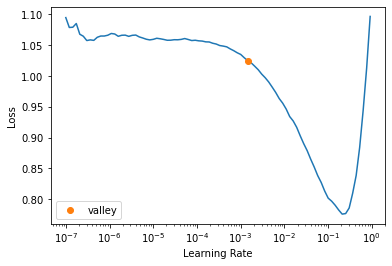

In [19]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet34_vl'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.768991,0.538651,0.597950,12:15
1,0.434557,0.281986,0.781274,12:17
2,0.267814,0.204492,0.821324,12:12
3,0.224164,0.177029,0.847675,12:15


Better model found at epoch 0 with valid_loss value: 0.5386509895324707.


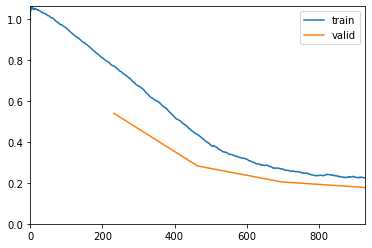

Better model found at epoch 1 with valid_loss value: 0.28198572993278503.
Better model found at epoch 2 with valid_loss value: 0.2044915109872818.
Better model found at epoch 3 with valid_loss value: 0.17702914774417877.


epoch,train_loss,valid_loss,f1_score,time
0,0.175615,0.139998,0.868873,12:34
1,0.149623,0.134791,0.873164,13:23
2,0.130336,0.115727,0.890519,14:08
3,0.119907,0.113342,0.898499,14:22
4,0.103694,0.117996,0.894333,13:59
5,0.078171,0.114725,0.909131,13:08
6,0.065731,0.116756,0.907989,12:54
7,0.054973,0.124817,0.906108,12:53
8,0.041987,0.123879,0.906289,12:49
9,0.037150,0.124591,0.909084,12:41


Better model found at epoch 0 with valid_loss value: 0.13999812304973602.


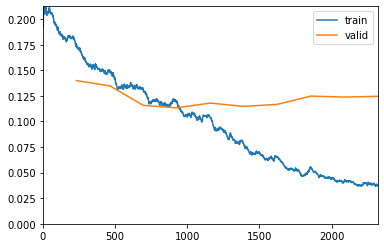

Better model found at epoch 1 with valid_loss value: 0.13479097187519073.
Better model found at epoch 2 with valid_loss value: 0.11572695523500443.
Better model found at epoch 3 with valid_loss value: 0.11334162950515747.


In [20]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [25]:
learn.export('plant_resnet34_vl.pkl') # save the model

In [26]:
learn = load_learner('plant_resnet34_vl.pkl') # load the model

### Fine-tune a Resnet50

SuggestedLRs(valley=0.0012022644514217973)

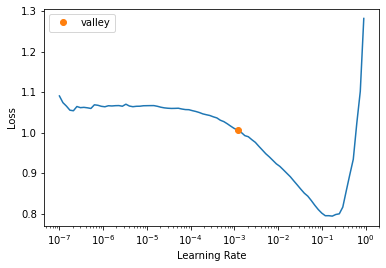

In [ ]:
dls = dblock.dataloaders(df, bs=40)

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet50_vl'
                     
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.632996,0.440736,0.672531,13:50
1,0.318292,0.217760,0.823183,13:48
2,0.231417,0.174067,0.842344,13:48
3,0.184981,0.144905,0.868993,13:48


Better model found at epoch 0 with valid_loss value: 0.44073644280433655.


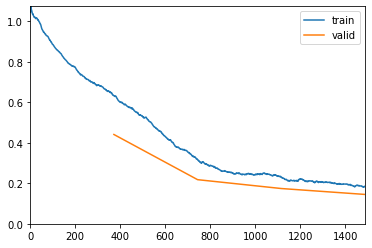

Better model found at epoch 1 with valid_loss value: 0.21775996685028076.
Better model found at epoch 2 with valid_loss value: 0.1740671843290329.
Better model found at epoch 3 with valid_loss value: 0.1449045091867447.


epoch,train_loss,valid_loss,f1_score,time
0,0.153082,0.124285,0.880312,17:42
1,0.150060,0.119726,0.882749,17:39
2,0.141043,0.114053,0.887124,17:41
3,0.118686,0.106248,0.907734,17:40
4,0.100668,0.106360,0.908615,17:41
5,0.086338,0.120679,0.901568,17:42
6,0.071235,0.113509,0.900089,22:58
7,0.053109,0.114024,0.910388,25:06
8,0.046862,0.116744,0.907894,25:18
9,0.041683,0.116617,0.909908,25:48


Better model found at epoch 0 with valid_loss value: 0.12428475171327591.


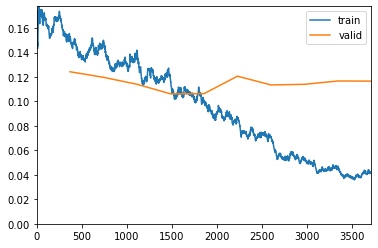

Better model found at epoch 1 with valid_loss value: 0.11972583830356598.
Better model found at epoch 2 with valid_loss value: 0.11405342817306519.
Better model found at epoch 3 with valid_loss value: 0.10624836385250092.


In [16]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [17]:
learn.export('plant_resnet50_vl.pkl') # save the model

In [18]:
learn = load_learner('plant_resnet50_vl.pkl') # load the model

### Fine-tune a Resnet101

SuggestedLRs(valley=0.0008317637839354575)

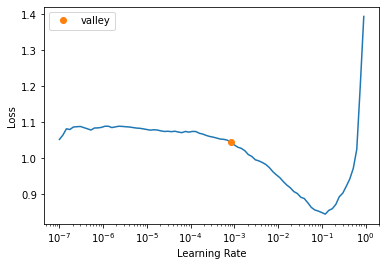

In [16]:
dls = dblock.dataloaders(df, bs=26)

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet101_vl'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.643606,0.444869,0.669923,20:00
1,0.323704,0.221524,0.816929,19:54
2,0.219350,0.167439,0.857834,19:51
3,0.183841,0.148699,0.871288,19:53


Better model found at epoch 0 with valid_loss value: 0.44486910104751587.


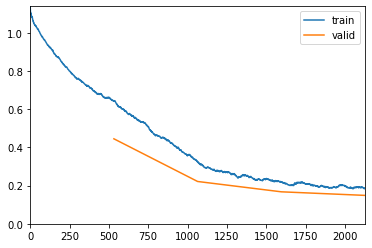

Better model found at epoch 1 with valid_loss value: 0.22152374684810638.
Better model found at epoch 2 with valid_loss value: 0.16743871569633484.
Better model found at epoch 3 with valid_loss value: 0.1486991047859192.


epoch,train_loss,valid_loss,f1_score,time


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 11.92 GiB total capacity; 11.11 GiB already allocated; 31.12 MiB free; 11.14 GiB reserved in total by PyTorch)

In [17]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [ ]:
learn.export('plant_resnet101_vl.pkl') # save the model

In [ ]:
learn = load_learner('plant_resnet101_vl.pkl') # load the model

### Resnet152

SuggestedLRs(valley=0.0010000000474974513)

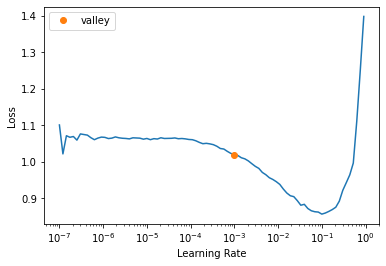

In [21]:
dls = dblock.dataloaders(df, bs=20)

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet152_vl'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.576995,0.408969,0.695711,29:26


Better model found at epoch 0 with valid_loss value: 0.40896856784820557.


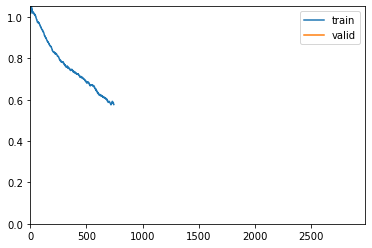

KeyboardInterrupt: 

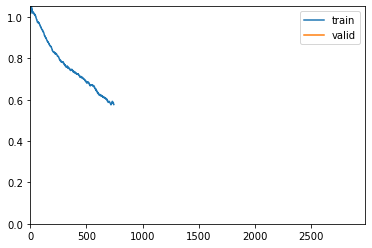

In [22]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [ ]:
learn.export('plant_resnet152_vl.pkl') # save the model

In [ ]:
learn = load_learner('plant_resnet152_vl.pkl') # load the model

### Resnet18 Practice

In [1]:
from fastai.vision.all import *
%config Completer.use_jedi = False
%matplotlib inline

In [2]:
valid_pct = 0.2
path = Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/')
df = pd.read_csv(path/'train.csv')

def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']
dblock = DataBlock(
                   blocks=[ImageBlock, MultiCategoryBlock],
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=valid_pct, seed=42),
                   item_tfms=RandomResizedCrop(540, min_scale=0.35)
                  )
loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=64)

SuggestedLRs(valley=0.0010000000474974513)

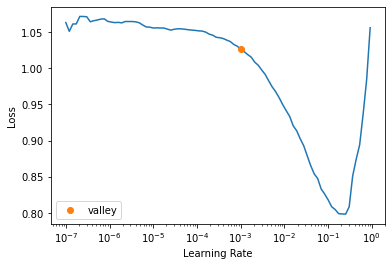

In [9]:
learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet18_test_vl'
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.654190,0.435680,0.672424,11:57
1,0.317090,0.230182,0.806516,11:55
2,0.229268,0.187779,0.830766,11:55
3,0.207295,0.164465,0.843241,11:53


Better model found at epoch 0 with valid_loss value: 0.435680091381073.


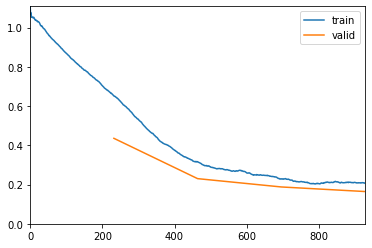

Better model found at epoch 1 with valid_loss value: 0.23018208146095276.
Better model found at epoch 2 with valid_loss value: 0.1877788007259369.
Better model found at epoch 3 with valid_loss value: 0.1644648015499115.


epoch,train_loss,valid_loss,f1_score,time
0,0.164397,0.141281,0.868939,11:59
1,0.152786,0.138494,0.880154,12:11
2,0.130930,0.141748,0.876009,12:17
3,0.126755,0.118369,0.884417,13:44
4,0.109476,0.125629,0.891319,13:47
5,0.088316,0.112432,0.905509,13:54
6,0.079701,0.120498,0.897549,12:59
7,0.055580,0.114154,0.909318,12:30
8,0.047190,0.122541,0.906675,12:31
9,0.040996,0.122060,0.909321,12:32


Better model found at epoch 0 with valid_loss value: 0.1412813812494278.


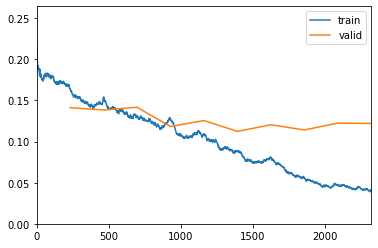

Better model found at epoch 1 with valid_loss value: 0.13849367201328278.
Better model found at epoch 3 with valid_loss value: 0.118369460105896.
Better model found at epoch 5 with valid_loss value: 0.1124316155910492.


In [10]:
learn.fine_tune(10, base_lr=3e-3, freeze_epochs=4)

SuggestedLRs(valley=3.630780702224001e-05)

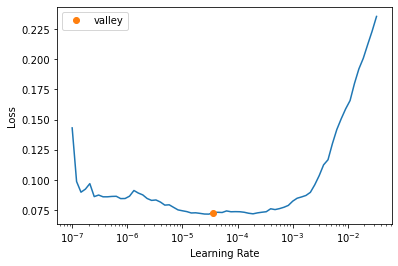

In [11]:
lrMin = learn.lr_find()
lrMin

In [40]:
learn.fit_one_cycle(2, lr_max=3e-5)

epoch,train_loss,valid_loss,f1_score,time
0,0.043881,0.129220,0.905478,12:40
1,0.038304,0.128361,0.903265,12:57


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd2cb1bc940>
Traceback (most recent call last):
  File "/home/xar/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/xar/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/xar/miniconda3/envs/fastai/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd2cb1bc940>
Traceback (most recent call last):
  File "/home/xar/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/xar/miniconda3/envs/fastai/lib/python3.8/site-p

### Parallel test

In [15]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *

# path = rank0_first(untar_data, URLs.IMAGEWOOF_320)
# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     splitter=GrandparentSplitter(valid_name='val'),
#     get_items=get_image_files, get_y=parent_label,
#     item_tfms=[RandomResizedCrop(160), FlipItem(0.5)],
#     batch_tfms=Normalize.from_stats(*imagenet_stats)
# ).dataloaders(path, path=path, bs=64)
dls = dblock.dataloaders(df, bs=128)

# learn = Learner(dls, xresnet50(n_out=10), metrics=[accuracy,top_k_accuracy]).to_native_fp16()
learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5)
                   )

In [16]:
with learn.distrib_ctx(): learn.fine_tune(4, 3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time


RuntimeError: CUDA out of memory. Tried to allocate 570.00 MiB (GPU 0; 11.92 GiB total capacity; 10.58 GiB already allocated; 187.50 MiB free; 11.04 GiB reserved in total by PyTorch)